# LELEC2885 TP1 - Part 2 - Exercises on images

Time to practice! We'll now use what we know of Python and images to implement an efficient convolution algorithm and the laplacian pyramid algorithm. If you feel lost, don't hesitate to go back to the **TP0** notebook.

If you know how to express things in Matlab, then [this cheat sheet](http://mathesaurus.sourceforge.net/matlab-python-xref.pdf) may help you convert them to Python.

In [4]:
# Dependencies for this notebook
!pip install pip -U
!pip3 install -q numpy imageio matplotlib scipy

Requirement already up-to-date: pip in /Users/romaingrx/Documents/Python/venv/deep/lib/python3.8/site-packages (20.2.3)


In [5]:
# Required imports
import numpy as np
import scipy.signal as sig
from matplotlib import pyplot as plt
import imageio

First, let us load an image that will serve as running example for this notebook, using the method we learned in the previous notebook.

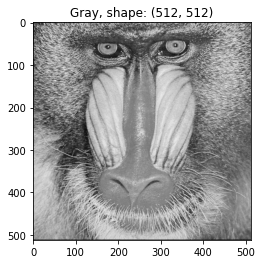

In [7]:
baboon_gray = imageio.imread("images/baboon.png", pilmode="L")

plt.title("Gray, shape: {}".format(baboon_gray.shape))
plt.imshow(baboon_gray, cmap="gray")  # Use the gray color map
plt.show()

## Image convolution

### Straightforward ("naive") convolution implementation
Define the convolution operation of an $N \times N$ image $f$ with a $k \times k$ kernel $h$ as

$$ (f * h)(i,j) = \sum_{i'=1}^{K} \sum_{j'=1}^K f(i-i',j-j') h(i',j') \quad \forall i,j = 1, ..., N.$$

**Question:** complete the function below which performs the convolution operation (you should read the `scipy.signal` documentation).

Do not test it just yet, we will do that in a little while.

In [46]:
def naive_convolution(image, kernel):
    """The convolution2d function offered with the library scipy.signal has a naive implementation.
    Please use it here to provide a first naive convolution function that conserves image size.
    """
    import scipy

    result = scipy.signal.convolve(image, kernel, mode='same', method='direct')
    
    return result

### Faster implementation
This "straightforward" (one might say, "naive") implementation of the convolution of the $N \times N$ signal $f$ with the $k \times k$ kernel $h$ has complexity $\mathcal{O}(N^2k^2)$, which becomes prohibitive when $k$ is of the order of $N$. Fortunately, a convolution in spatial domain is equivalent to an element-wise multiplication in the Fourier domain ($\odot$ denotes the Hadamard (element-wise) product):

$$f * h = \mathcal{F^{-1}} ( \mathcal{F f} \odot \mathcal{F h} ).$$

Computing the convolution this way should bring a large speedup, since the Fast Fourier Transform of an $N \times N$ image has an algorithmic complexity of $\mathcal{O}(N^2\log N^2)$ (we assume for simplicity that $N$ is a power of $2$).

**Question:** Can you complete the following code implementing convolution in the Fourier domain?

In [47]:
def resize_and_fix_origin(kernel, size):
    """Pads a kernel to reach shape `size`, and shift it in order to cancel phase.
    This is based on the assumption that the kernel is centered in image space.
    """
    # Very specific routine... You don't have to understand it
    pad0, pad1 = size[0]-kernel.shape[0], size[1]-kernel.shape[1]
    # shift less if kernel is even, to start with 2 central items
    shift0, shift1 = (kernel.shape[0]-1)//2, (kernel.shape[1]-1)//2

    kernel = np.pad(kernel, ((0,pad0), (0,pad1)))
    kernel = np.roll(kernel, (-shift0, -shift1), axis=(0,1))
    return kernel


def fast_convolution(image, kernel):
    """The library numpy.fft offers functions to implement the fast fourrier transform.
    Please implement a fast convolution algorithm using it.
    
    Be careful! In order to be multiplied elementwise, the Fourier representations have to
    be the same size. Furthermore, a centered kernel will introduce a phase in the Fourier
    domain, which introduces a shift in the final result.
    
    In order to cope with those two problems, you can call resize_and_fix_origin defined
    above
    """
    
    kernel_pad = resize_and_fix_origin(kernel, image.shape)
    
    image_fft = np.fft.fft2(image)
    kernel_fft = np.fft.fft2(kernel_pad)

    
    fft_result = kernel_fft * image_fft
    
    result = np.fft.ifft2(fft_result)
    
    return np.real(result)

To be able to try these functions out, let us first initialize some gaussian kernel. This is also an opportunity to see how `resize_and_fix_origin` actually "fixes the origin" of the kernel.

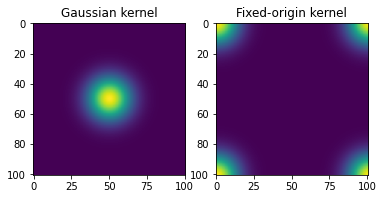

In [48]:
def gaussian_kernel(sigma,n):
    """Returns a n-by-n gaussian kernel (point spread function) with scale sigma.
    Centered when shift=False."""
    indices = np.linspace(-n/2,n/2,n)
    [X,Y] = np.meshgrid(indices,indices)
    h = np.exp( -(X**2+Y**2)/(2.0*(sigma)**2) )
    h /= h.sum() # Normalize
    return h

kernel = gaussian_kernel(10, 101)  # Small kernel for naive convolution
plt.subplot(121, title="Gaussian kernel")
plt.imshow(kernel)
plt.subplot(122, title="Fixed-origin kernel")
plt.imshow(resize_and_fix_origin(kernel, kernel.shape))
plt.show()

After having implemented the fast and naive convolutions, the following cell should show blurry versions of the baboon image.

Do you observe any difference in terms of running time between the two implementations ?

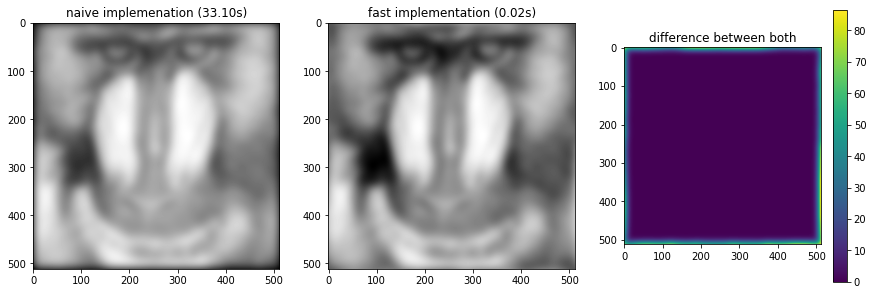

In [49]:
import time
tic = time.time()
naive_result = naive_convolution(baboon_gray, kernel)
tac = time.time()
fast_result = fast_convolution(baboon_gray, kernel)
toc = time.time()

plt.figure(figsize=(15,5))
plt.subplot(131, title="naive implemenation ({0:.2f}s)".format(tac-tic))
plt.imshow(naive_result, cmap="gray")
plt.subplot(132, title="fast implementation ({0:.2f}s)".format(toc-tac))
plt.imshow(fast_result, cmap="gray")
plt.subplot(133, title="difference between both")
plt.imshow(np.abs(naive_result-fast_result))
plt.colorbar()
plt.show()

Do you achieve similar results using both algorithms ? What about the timing ?

## A Multi-Scale Representation: The Laplacian Pyramid

One of the advantages of the Fourier representation of an image is that it allows to easily separate the low-frequency content, i.e., the "smooth content" of the image, from the high-frequency content, i.e., the "details" of the image. However, in the Fourier representation all the spatial information is "mixed up", making it hard for instance to localize objects.

In image processing, we often desire a representation that achieves a tradeoff between accurate frequency and spatial localization. This is the rationale behind time-frequency representations of images: the most basic example of those is the **Laplacian Pyramid Representation**.

The idea is quite simple:


1. Start with $i=0$ and your image at full resolution $I_0$  ($i$ denotes the resolution index).
1. Blur $I_i$ with a gaussian kernel to obtain $B_i$, the blurred image at level $i$.
1. Downsample $B_i$ to obtain $I_{i+1}$, the image at one lower resolution level (without *aliasing* thanks to the blur).
1. *Expand* $I_{i+1}$ back to the resolution $i$ to obtain $I'_{i+1}$, *i.e.,* by zero-padding in the frequency domain.
1. Store the difference $D_i = I_i-I'_{i+1}$. We say that $D_i$ contains the *details* at resolution $i$.
1. Start over at step 2 with $i\gets i+1$ until the resolution level $i$ is "coarse" enough. At the last step $i_{\max}$, also store the coarsest image $I_{i_{\max}}.$ 

This way, when you look at $D_i$, you are able to analyze the *spatial* content of the image at a given *resolution* $i$: the smallest (resp. largest) value of $i$ corresponds to the highest (resp. lowest) frequency content. Let's look at it in practice to understand what's going on.


Can you complete the following code ?

In [55]:
def blur(I_i):
    """Blurs the image I_i for the Laplacian pyramid algorithm."""
    kernel = gaussian_kernel(5., len(I_i))
    
    B_i = fast_convolution(I_i, kernel)

    return B_i

def downSample(B_i):
    """Downsamples the image B_i by keeping one pixel out of two samples in each direction).
    This is called 2x2 data binning."""
    I_iplus1 = B_i[::2,::2]

    return I_iplus1

def expand(I_iplus1):
    """Upsamples (interpolate on twice the size) I_iplus1 by zero-padding it in the frequency domain."""
    
    # TODO
    Iprime_iplus1 = None
    
    return Iprime_iplus1

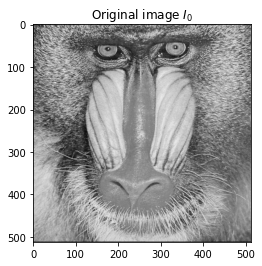

NameError: name 'I_iplus1' is not defined

In [53]:
from TP1_utils import plot_pyramid
# Build a Laplacian pyramid
I_0 = baboon_gray # Some test image here

# Initialization
I_i = I_0
i_max = 3

plt.imshow(I_i,cmap='gray')
plt.title(r'Original image $I_0$')
plt.show()

pyramid = []

# Build the Pyramid
for i in range(i_max):
    # TO COMPLETE
    
    # Iterate
    I_i = I_iplus1
    
    plt.figure(figsize=(10,5))
    plt.subplot(121, title='Image $I_{}$'.format(i+1))
    plt.imshow(I_i,cmap='gray')
    plt.subplot(122, title='Details $D_{}$'.format(i))
    plt.imshow(D_i,cmap='gray')
    plt.colorbar() # Interesting, allows to observe how the details decrease in amplitude
    plt.show()
    
    pyramid.append(D_i)
pyramid.append(I_i)

plt.figure(figsize=(15,8))
plt.title("The complete Laplacian Pyramid")
plot_pyramid(pyramid)
plt.show()

Now, time for some critical thinking. Can you answer the following questions?

**Question 1:** What is the deepest level $i_{\max}$ of the pyramid? Run the pyramid for this value.


**Question 2:** In step 4, why can't we simply take $B_i$ instead of $I'_{i+1}$?

**Question 3:**. Rougly, how large/small should the blur size ($\sigma$) be, e.g., with respect to n? *Hint: think about the Shannon-Nyquist theorem!*

**Question 4:** In the pyramid, we store the details $D_i$ for all $i$ and the lowest resolution image $I_{i_{\max}}$. How can we construct the initial image $I_0$ (and the intermediatry images $I_i$) back from the Laplacian pyramid? Implement this scheme.
